# **Lab Task: Build K‑Nearest Neighbors (KNN) Classifier from Scratch**

## **Objective :**
- Implement the KNN classification algorithm in Python without using scikit‑learn’s KNeighborsClassifier.

- Practice data loading, cleaning, feature scaling, and train/test splitting.

- Evaluate your classifier’s performance using accuracy, precision, recall, and a confusion matrix.

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from scipy import stats

## **1. Data loading**


In [34]:
import kagglehub
import pandas as pd

# Step 1: Download latest version of the dataset
path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")
print("Path to dataset files:", path)

# Step 2: Load the dataset
df = pd.read_csv(f"{path}/data.csv", index_col='id').reset_index(drop=True)
df.head()

Path to dataset files: /kaggle/input/breast-cancer-wisconsin-data


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## **2. Data Preprocessing**

- **Identify missing values**
- **Handle missing data (choose one)**
- **Feature scaling**
- **Train/Test split**: Split into 70% train / 30% test (use random_state=42).

In [35]:
# Drop the 'Unnamed: 32' column if it exists (commonly an empty column from CSVs)
df.drop(columns=['Unnamed: 32'], errors='ignore', inplace=True)

# Encode the target variable 'diagnosis': Malignant (M) as 1, Benign (B) as 0
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Check for any missing values in the dataset
print(df.isnull().sum().sort_values(ascending=False))

# Separate the features (X) from the target (y)
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Feature scaling using StandardScaler to normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets (70% train, 30% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


## **Implement KNN Class**

In [36]:
import numpy as np
from collections import Counter

class kNN():
    '''k-Nearest Neighbours Classifier'''

    def __init__(self, k=3, metric='euclidean', p=2):
        """
        Initialize the kNN classifier.
        Parameters:
            k (int): Number of nearest neighbors to consider.
            metric (str): Distance metric to use ('euclidean', 'manhattan', or 'minkowski').
            p (int): Power parameter for Minkowski distance.
        """
        self.k = k
        self.metric = metric
        self.p = p

    # Euclidean distance (L2 norm)
    def euclidean(self, v1, v2):
        """
        Calculate the Euclidean distance between two vectors.
        """
        return np.sqrt(np.sum((v1 - v2) ** 2))

    # Manhattan distance (L1 norm)
    def manhattan(self, v1, v2):
        """
        Calculate the Manhattan distance between two vectors.
        """
        return np.sum(np.abs(v1 - v2))

    # Minkowski distance (Lp norm)
    def minkowski(self, v1, v2, p=2):
        """
        Calculate the Minkowski distance between two vectors.
        """
        return np.sum(np.abs(v1 - v2) ** p) ** (1 / p)

    # Choose the appropriate distance metric
    def compute_distance(self, v1, v2):
        """
        Compute distance between two vectors using the specified metric.
        """
        if self.metric == 'euclidean':
            return self.euclidean(v1, v2)
        elif self.metric == 'manhattan':
            return self.manhattan(v1, v2)
        elif self.metric == 'minkowski':
            return self.minkowski(v1, v2, self.p)
        else:
            raise ValueError(f"Unsupported distance metric: {self.metric}")

    # Store the training dataset
    def fit(self, X_train, y_train):
        """
        Store the training data for future reference.
        Parameters:
            X_train (array-like): Training feature set.
            y_train (array-like): Training labels.
        """
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train)

    # Find the k nearest neighbours of a test data point
    def get_neighbours(self, test_row):
        """
        Find k nearest neighbors for a single test instance.
        Parameters:
            test_row (array-like): A single test data point.
        Returns:
            List of labels of the k nearest neighbors.
        """
        distances = []
        for i in range(len(self.X_train)):
            dist = self.compute_distance(test_row, self.X_train[i])
            distances.append((dist, self.y_train[i]))  # Store distance and corresponding label
        distances.sort(key=lambda x: x[0])  # Sort neighbors by distance
        neighbours = [label for _, label in distances[:self.k]]  # Extract labels of k nearest
        return neighbours

    # Predict the label for each test instance
    def predict(self, X_test):
        """
        Predict the class labels for the test set.
        Parameters:
            X_test (array-like): Test feature set.
        Returns:
            Array of predicted labels.
        """
        predictions = []
        for row in X_test:
            neighbours = self.get_neighbours(row)  # Get nearest neighbors
            majority_vote = Counter(neighbours).most_common(1)[0][0]  # Majority class label
            predictions.append(majority_vote)
        return np.array(predictions)


## **Evaluate the model**


Fine the following performance matrices results:
- Accuracy (overall correct rate)

- Precision (true positives ÷ predicted positives)

- Recall (true positives ÷ actual positives)

- Confusion Matrix

- Classfication Report

In [37]:
# Initialize the custom kNN classifier with k=5
knn = kNN(k=5)

# Fit the classifier using the training data
knn.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = knn.predict(X_test)

# Import evaluation metrics from scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

# Calculate and display evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))                  # Proportion of correct predictions
print("Precision:", precision_score(y_test, y_pred))                # True positives / (true positives + false positives)
print("Recall:", recall_score(y_test, y_pred))                      # True positives / (true positives + false negatives)

# Display the confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))    # Matrix showing true vs predicted labels

# Display a detailed classification report (includes precision, recall, f1-score, and support)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9590643274853801
Precision: 0.9516129032258065
Recall: 0.9365079365079365

Confusion Matrix:
 [[105   3]
 [  4  59]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       108
           1       0.95      0.94      0.94        63

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



## **Effect of k on Classification Accuracy**

- For each k from 3 to 29, fit your k‑NN on the training set and record test accuracy.

- Plot k (on the x‑axis) vs. accuracy (on the y‑axis), with markers and clear labels.

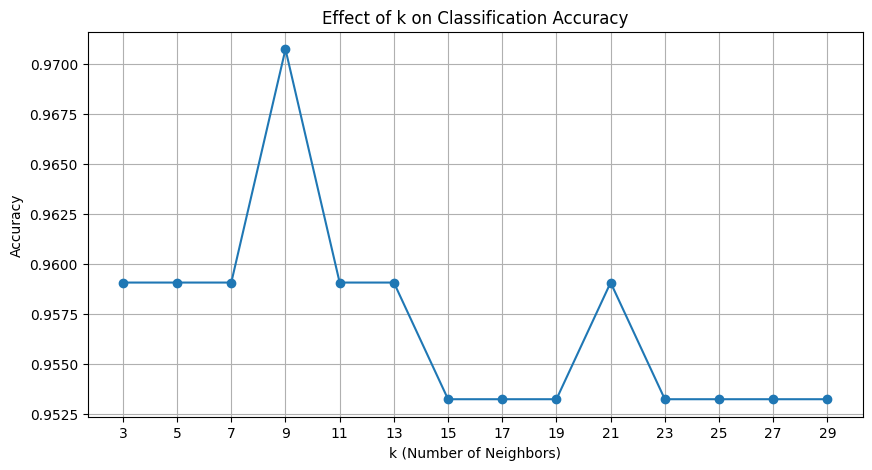

In [38]:
# List to store accuracy values for different k
accuracies = []

# List of odd k values from 3 to 29 (inclusive)
ks = list(range(3, 30, 2))

# Evaluate accuracy for each k
for k in ks:
    model = kNN(k=k)                     # Initialize kNN model with current k
    model.fit(X_train, y_train)          # Train the model
    preds = model.predict(X_test)        # Predict on the test data
    acc = accuracy_score(y_test, preds)  # Calculate accuracy
    accuracies.append(acc)               # Store the result

# Plotting accuracy vs. k
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))                       # Set figure size
plt.plot(ks, accuracies, marker='o', linestyle='-')  # Plot accuracy with line and markers
plt.title('Effect of k on Classification Accuracy')  # Set plot title
plt.xlabel('k (Number of Neighbors)')                # X-axis label
plt.ylabel('Accuracy')                               # Y-axis label
plt.grid(True)                                       # Show grid for better readability
plt.xticks(ks)                                       # Show all k values on x-axis
plt.show()                                           # Display the plot
